In [1]:
import os
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, roc_auc_score, precision_score, recall_score, f1_score, accuracy_score
from sklearn.calibration import calibration_curve
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_selection import RFECV
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OrdinalEncoder, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from imblearn.over_sampling import SMOTE




In [2]:
import pandas as pd

def filter_dataframe_by_numbers(df_source, df_filter, column_name='Number'):
    """
    根据 df_filter 中的 'Number' 列筛选 df_source 中的行。
    
    参数:
    - df_source (pd.DataFrame): 要筛选的源 DataFrame。
    - df_filter (pd.DataFrame): 包含筛选条件的 DataFrame。
    - column_name (str): 用于筛选的列名，默认为 'Number'。
    
    返回:
    - pd.DataFrame: 包含与 df_filter 中 'Number' 列相匹配的所有行的 DataFrame。
    """
    # 确保两个 DataFrame 都有相同的列名
    assert column_name in df_source.columns, f"Column '{column_name}' not found in the source DataFrame."
    assert column_name in df_filter.columns, f"Column '{column_name}' not found in the filter DataFrame."

    # 获取 df_filter 中 'Number' 列的唯一值
    numbers_to_filter = df_filter[column_name].unique()

    # 使用 isin 方法来筛选 df_source 中的行
    filtered_df = df_source[df_source[column_name].isin(numbers_to_filter)]

    return filtered_df

In [31]:
from sklearn.preprocessing import StandardScaler, OrdinalEncoder, OneHotEncoder
from sklearn.model_selection import train_test_split


ori_data = pd.read_csv('dataset/processed_data.csv')

# 分离特征和目标变量
X_with_number = ori_data.drop('Y', axis=1)
y = ori_data['Y']

# 分割数据集
X_internal, X_external, y_internal, y_external = train_test_split(X_with_number, 
                                                                  y, 
                                                                  test_size=0.3, 
                                                                  random_state=42, 
                                                                  stratify=y)
_internal_before_scaled = X_internal.copy()
_internal_before_scaled['Y'] = y_internal.values
_internal_before_scaled.to_csv("output_data_LOGISTIC/internal_data.csv", index=False)
_external_before_scaled = X_external.copy()
_external_before_scaled['Y'] = y_external.values
_external_before_scaled.to_csv("output_data_LOGISTIC/external_data.csv", index=False)

X_internal_names = X_internal['Number'].values
X_external_names = X_external['Number'].values
# 删除编号列用于标准化
X_internal_for_scale = X_internal.drop(columns=['Number'])
X_external_for_scale = X_external.drop(columns=['Number'])
# 标准化内部数据集
scaler = StandardScaler()
X_internal_scaled = scaler.fit_transform(X_internal_for_scale)
X_internal = pd.DataFrame(X_internal_scaled, columns=X_internal.drop(columns=['Number']).columns)
# 标准化外部验证集
X_external_scaled = scaler.transform(X_external_for_scale)
X_external = pd.DataFrame(X_external_scaled, columns=X_external.drop(columns=['Number']).columns)


In [29]:
_internal_data = X_internal.copy()
_internal_data['Number'] = X_internal_names
_internal_data['Y'] = y_internal.values

_external_data = X_external.copy()
_external_data['Number'] = X_external_names
_external_data['Y'] = y_external.values

_internal_data.to_csv('output_data_LOGISTIC/internal_scaled_data.csv', index=False)
_external_data.to_csv('output_data_LOGISTIC/external_scaled_data.csv', index=False)

In [4]:
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_selection import RFECV
from sklearn.model_selection import StratifiedKFold


def feature_selection(X_for_selection, y_for_selection):
    # 初始化模型
    model = RandomForestClassifier(random_state=42)

    # 使用带交叉验证的递归特征消除
    X_train = X_for_selection
    y_train = y_for_selection

    rfecv = RFECV(estimator=model, step=1, cv=StratifiedKFold(5), scoring='roc_auc')
    rfecv = rfecv.fit(X_train, y_train)

    print("Optimal number of features: ", rfecv.n_features_)
    print("Selected Features: ", rfecv.support_)
    print("Feature Ranking: ", rfecv.ranking_)

    return rfecv


X_for_selection = X_internal
y_for_selection = y_internal
rfecv = feature_selection(X_for_selection=X_for_selection, 
                          y_for_selection=y_for_selection
                          )

Optimal number of features:  19
Selected Features:  [ True  True  True  True  True  True  True  True False False False False
 False False  True False  True  True False False False False False  True
  True False  True False False False False False False False False False
 False False False False  True False False False False False False False
 False False False False False  True  True False  True False  True False
 False False False False False False False False False False False False
 False]
Feature Ranking:  [ 1  1  1  1  1  1  1  1 15 45 24 37 47 32  1 28  1  1  4 30  7 11 22  1
  1  6  1 27  3 43 42 16 48 21 51  8 31 35 41 20  1 13 50 18 29 36 53 38
 10 26 23 19 39  1  1 52  1  2  1 12 46 44 40 25 55 49 17  5 33 54  9 14
 34]


Text(19, 0.6952775160407413, '(19, 0.695)')

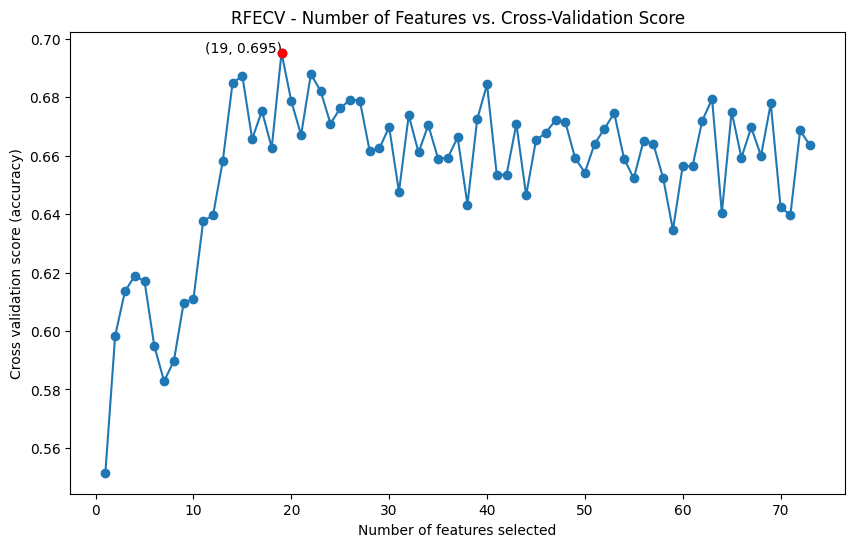

In [5]:
import matplotlib.pyplot as plt
import numpy as np
import os

# 特征名称
feature_names = X_for_selection.filter(regex='^X').columns

# 可视化特征选择过程中的交叉验证分数
plt.figure(figsize=(10, 6))
plt.xlabel("Number of features selected")
plt.ylabel("Cross validation score (accuracy)")
mean_test_scores = rfecv.cv_results_['mean_test_score']
plt.plot(range(1, len(mean_test_scores) + 1), mean_test_scores, marker='o')
plt.title('RFECV - Number of Features vs. Cross-Validation Score')

# 标出最高点及其对应的特征数量
optimal_idx = np.argmax(mean_test_scores)
optimal_score = mean_test_scores[optimal_idx]
plt.scatter(optimal_idx + 1, optimal_score, color='red', zorder=5)
plt.text(optimal_idx + 1, optimal_score, f'({optimal_idx + 1}, {optimal_score:.3f})', 
         horizontalalignment='right')

# base_path = f'results/{version_string}'
# plt.savefig(os.path.join(base_path, 'figures', 'FeatureSelection.png'))
# plt.show()


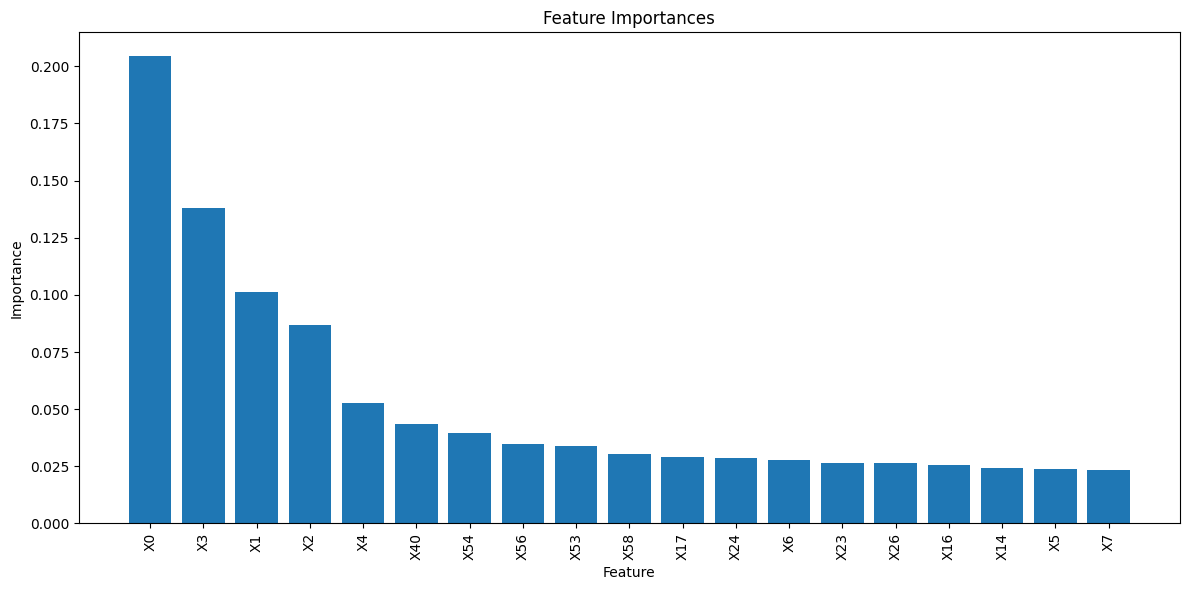

In [6]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestClassifier

# 假设您已经定义了 X_for_selection, y_for_selection, rfecv, 和 feature_names
# 这里我们直接使用您的代码片段中的部分

# 训练最终模型并获取特征重要性
final_model = RandomForestClassifier(random_state=42)
final_model.fit(X_for_selection.iloc[:, rfecv.support_], y_for_selection)
importances = final_model.feature_importances_

# 获取重要性排序的索引
sorted_indices = np.argsort(importances)[::-1]  # 降序排列

# 绘制特征重要性
plt.figure(figsize=(12, 6))
plt.title("Feature Importances")
plt.bar(range(X_for_selection.iloc[:, rfecv.support_].shape[1]),
        importances[sorted_indices],  # 使用排序后的索引
        align='center')
plt.xticks(range(X_for_selection.iloc[:, rfecv.support_].shape[1]),
           feature_names[rfecv.support_][sorted_indices],  # 使用排序后的索引
           rotation=90)
plt.ylabel("Importance")
plt.xlabel("Feature")
plt.tight_layout()  # 自动调整子图参数，使之填充整个图像区域
plt.show()

In [7]:
X_internal_selected_scaled = X_for_selection.iloc[:, rfecv.support_]
y_internal_selected_scaled = y_internal
X_external_selected_scaled = X_external.iloc[:, rfecv.support_]
y_external_selected_scaled = y_external

## raw

Internal Set Classification Report:
              precision    recall  f1-score   support

           0       0.93      0.69      0.79       574
           1       0.23      0.63      0.33        83

    accuracy                           0.68       657
   macro avg       0.58      0.66      0.56       657
weighted avg       0.84      0.68      0.74       657

External Set Classification Report:
              precision    recall  f1-score   support

           0       0.94      0.66      0.78       247
           1       0.23      0.71      0.35        35

    accuracy                           0.67       282
   macro avg       0.59      0.69      0.56       282
weighted avg       0.85      0.67      0.73       282



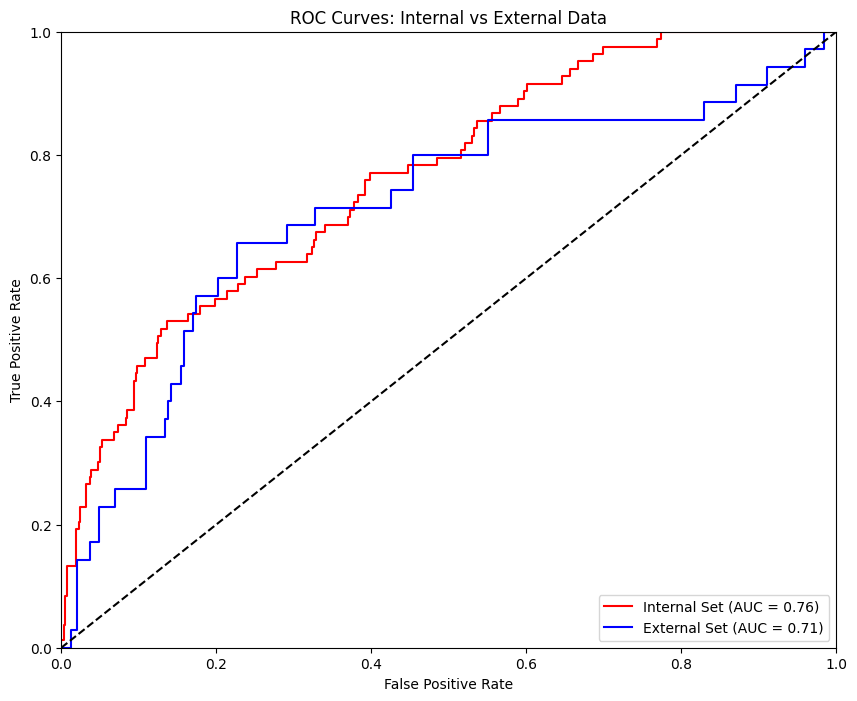

In [18]:
import numpy as np
import pandas as pd
import os
import joblib
from sklearn.linear_model import LogisticRegression
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import classification_report, roc_curve, roc_auc_score, accuracy_score, precision_score, recall_score, f1_score


# 创建保存文件夹
os.makedirs('output_data_LOGISTIC', exist_ok=True)
os.makedirs('output_data_LOGISTIC/models', exist_ok=True)
os.makedirs('output_data_LOGISTIC/reports', exist_ok=True)
os.makedirs('output_data_LOGISTIC/roc_curves', exist_ok=True)
os.makedirs('output_data_LOGISTIC/probabilities', exist_ok=True)


def calculate_best_cutoff(fpr, tpr, thresholds):
    J = tpr - fpr
    best_idx = np.argmax(J)
    best_threshold = thresholds[best_idx]
    return best_threshold, fpr[best_idx], tpr[best_idx]


def calculate_metrics_at_cutoff(y_true, y_pred_prob, best_cutoff):
    y_pred = (y_pred_prob >= best_cutoff).astype(int)
    accuracy = accuracy_score(y_true, y_pred)
    precision = precision_score(y_true, y_pred)
    recall = recall_score(y_true, y_pred)
    f1 = f1_score(y_true, y_pred)
    return accuracy, precision, recall, f1


def five_fold_and_predict(X_internal, y_internal, X_external, y_external):
    # 设置五折交叉验证
    kf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
    best_model = None
    best_auc = 0

    # 交叉验证过程
    for train_index, val_index in kf.split(X_internal, y_internal):
        X_train, X_val = X_internal.iloc[train_index], X_internal.iloc[val_index]
        y_train, y_val = y_internal.iloc[train_index], y_internal.iloc[val_index]
        
        # 使用SMOTE进行上采样
        smote = SMOTE(random_state=42)
        X_train_resampled, y_train_resampled = smote.fit_resample(X_train, y_train)
        
        # 训练 LOGISTIC 分类器
        model = LogisticRegression(random_state=42)
        model.fit(X_train_resampled, y_train_resampled)
        
        # 在验证集上预测
        y_pred_prob_val = model.predict_proba(X_val)[:, 1]
        auc_val = roc_auc_score(y_val, y_pred_prob_val)
        
        # 保存AUC最高的模型
        if auc_val > best_auc:
            best_auc = auc_val
            best_model = model

    # 在整个内部数据集上使用最佳模型进行预测
    y_pred_prob_internal = best_model.predict_proba(X_internal)[:, 1]
    y_pred_internal = best_model.predict(X_internal)
    print("Internal Set Classification Report:")
    print(classification_report(y_internal, y_pred_internal))

    # 在外部数据集上使用最佳模型进行预测
    y_pred_prob_external = best_model.predict_proba(X_external)[:, 1]
    y_pred_external = best_model.predict(X_external)
    print("External Set Classification Report:")
    print(classification_report(y_external, y_pred_external))

    # 绘制ROC曲线并计算AUC
    fpr_internal, tpr_internal, thresholds_internal = roc_curve(y_internal, y_pred_prob_internal)
    auc_internal = roc_auc_score(y_internal, y_pred_prob_internal)

    fpr_external, tpr_external, thresholds_external = roc_curve(y_external, y_pred_prob_external)
    auc_external = roc_auc_score(y_external, y_pred_prob_external)

    # 计算最佳cutoff值
    best_cutoff_internal, fpr_at_best_internal, tpr_at_best_internal = calculate_best_cutoff(fpr_internal, tpr_internal, thresholds_internal)
    best_cutoff_external, fpr_at_best_external, tpr_at_best_external = calculate_best_cutoff(fpr_external, tpr_external, thresholds_external)

    # 在最佳cutoff值下计算各项指标
    metrics_internal = calculate_metrics_at_cutoff(y_internal, y_pred_prob_internal, best_cutoff_internal)
    metrics_external = calculate_metrics_at_cutoff(y_external, y_pred_prob_external, best_cutoff_external)

    # 保存最佳cutoff值及对应的指标到CSV
    results = {
        'Dataset': ['Internal', 'External'],
        'Best Cutoff': [best_cutoff_internal, best_cutoff_external],
        'FPR at Best Cutoff': [fpr_at_best_internal, fpr_at_best_external],
        'TPR at Best Cutoff': [tpr_at_best_internal, tpr_at_best_external],
        'Accuracy': [metrics_internal[0], metrics_external[0]],
        'Precision': [metrics_internal[1], metrics_external[1]],
        'Recall': [metrics_internal[2], metrics_external[2]],
        'F1 Score': [metrics_internal[3], metrics_external[3]]
    }
    results_df = pd.DataFrame(results)
    results_df.to_csv('output_data_LOGISTIC/reports/best_cutoff_metrics.csv', index=False)

    # 绘制ROC曲线
    plt.figure(figsize=(10, 8))

    plt.plot(fpr_internal, tpr_internal, label=f'Internal Set (AUC = {auc_internal:.2f})', color='red')
    plt.plot(fpr_external, tpr_external, label=f'External Set (AUC = {auc_external:.2f})', color='blue')

    plt.plot([0, 1], [0, 1], 'k--')  # 绘制对角线
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.0])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC Curves: Internal vs External Data')
    plt.legend(loc="lower right")
    plt.savefig('output_data_LOGISTIC/roc_curves/compare_external_and_internal_roc_curve.png')
    plt.show()

    # 保存最佳模型
    joblib.dump(best_model, 'output_data_LOGISTIC/models/best_logistic_model.pkl')


# 调用函数进行五折交叉验证并预测
five_fold_and_predict(X_internal_selected_scaled, 
                      y_internal_selected_scaled, 
                      X_external_selected_scaled, 
                      y_external_selected_scaled
                      )


## save

In [9]:
import os
import numpy as np
import pandas as pd
import joblib
from imblearn.over_sampling import SMOTE
from sklearn.linear_model import LogisticRegression
# from xgboost import XGBClassifier
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.metrics import classification_report, roc_curve, roc_auc_score
import matplotlib.pyplot as plt

# 创建保存文件夹
os.makedirs('output_data_LOGISTIC', exist_ok=True)
os.makedirs('output_data_LOGISTIC/models', exist_ok=True)
os.makedirs('output_data_LOGISTIC/reports', exist_ok=True)
os.makedirs('output_data_LOGISTIC/roc_curves', exist_ok=True)
os.makedirs('output_data_LOGISTIC/probabilities', exist_ok=True)

def save_report(report, filename):
    report_df = pd.DataFrame(report).transpose()
    report_df.to_csv(filename)

def save_roc_curve(fpr, tpr, auc, title, filename):
    plt.figure(figsize=(10, 8))
    plt.plot(fpr, tpr, label=f'{title} (AUC = {auc:.2f})')
    plt.plot([0, 1], [0, 1], 'k--')  # 绘制对角线
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.0])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(title)
    plt.legend(loc="lower right")
    plt.savefig(filename)
    plt.close()

def five_fold_and_predict(X_internal, y_internal, X_external, y_external):
    # 设置五折交叉验证
    kf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
    best_model = None
    best_auc = 0
    i = 0

    for train_index, val_index in kf.split(X_internal, y_internal):
        X_train, X_val = X_internal.iloc[train_index], X_internal.iloc[val_index]
        y_train, y_val = y_internal.iloc[train_index], y_internal.iloc[val_index]
        
        # 保存每一折的训练集和验证集
        X_train.to_csv(f'output_data_LOGISTIC/train_fold_{i}.csv', index=False)
        y_train.to_csv(f'output_data_LOGISTIC/train_fold_{i}_labels.csv', index=False)
        X_val.to_csv(f'output_data_LOGISTIC/val_fold_{i}.csv', index=False)
        y_val.to_csv(f'output_data_LOGISTIC/val_fold_{i}_labels.csv', index=False)
        
        # 使用SMOTE进行上采样
        smote = SMOTE(random_state=42)
        X_train_resampled, y_train_resampled = smote.fit_resample(X_train, y_train)
        
        # 保存SMOTE采样后的数据
        X_train_resampled.to_csv(f'output_data_LOGISTIC/train_resampled_fold_{i}.csv', index=False)
        y_train_resampled.to_csv(f'output_data_LOGISTIC/train_resampled_fold_{i}_labels.csv', index=False)
        
        # 训练XGBoost分类器
        model = LogisticRegression(random_state=42)
        model.fit(X_train_resampled, y_train_resampled)
        
        # 在验证集上预测
        y_pred_prob_val = model.predict_proba(X_val)[:, 1]
        y_pred_val = model.predict(X_val)
        auc_val = roc_auc_score(y_val, y_pred_prob_val)
        
        # 保存每一折的classification_report
        report_val = classification_report(y_val, y_pred_val, output_dict=True)
        save_report(report_val, f'output_data_LOGISTIC/reports/val_report_fold_{i}.csv')
        
        # 保存每一折的预测概率
        pd.DataFrame({'y_true': y_val, 'y_pred_prob': y_pred_prob_val, 'y_pred': y_pred_val}).to_csv(
            f'output_data_LOGISTIC/probabilities/val_probabilities_fold_{i}.csv', index=False)
        
        # 保存AUC最高的模型
        if auc_val > best_auc:
            best_auc = auc_val
            best_model = model
        
        # 绘制并保存ROC曲线
        fpr_val, tpr_val, _ = roc_curve(y_val, y_pred_prob_val)
        save_roc_curve(fpr_val, tpr_val, auc_val, f'Validation Set Fold {i}', f'output_data_LOGISTIC/roc_curves/val_roc_curve_fold_{i}.png')

        print(f"Fold {i}, AUC: {auc_val:.4f}")
        i += 1

    # 在整个内部数据集上使用最佳模型进行预测
    y_pred_prob_internal = best_model.predict_proba(X_internal)[:, 1]
    y_pred_internal = best_model.predict(X_internal)
    
    # 保存内部数据集的classification_report
    report_internal = classification_report(y_internal, y_pred_internal, output_dict=True)
    save_report(report_internal, 'output_data_LOGISTIC/reports/internal_report.csv')

    # 在外部数据集上使用最佳模型进行预测
    y_pred_prob_external = best_model.predict_proba(X_external)[:, 1]
    y_pred_external = best_model.predict(X_external)
    
    # 保存外部数据集的classification_report
    report_external = classification_report(y_external, y_pred_external, output_dict=True)
    save_report(report_external, 'output_data_LOGISTIC/reports/external_report.csv')

    # 保存内部和外部数据集的预测概率和标签
    pd.DataFrame({'y_true': y_internal, 'y_pred_prob': y_pred_prob_internal, 'y_pred': y_pred_internal}).to_csv(
        'output_data_LOGISTIC/probabilities/internal_probabilities.csv', index=False)
    pd.DataFrame({'y_true': y_external, 'y_pred_prob': y_pred_prob_external, 'y_pred': y_pred_external}).to_csv(
        'output_data_LOGISTIC/probabilities/external_probabilities.csv', index=False)
    
    # 绘制并保存内部数据集的ROC曲线
    fpr_internal, tpr_internal, _ = roc_curve(y_internal, y_pred_prob_internal)
    auc_internal = roc_auc_score(y_internal, y_pred_prob_internal)
    save_roc_curve(fpr_internal, tpr_internal, auc_internal, 'Internal Set', 'output_data_LOGISTIC/roc_curves/internal_roc_curve.png')

    # 绘制并保存外部数据集的ROC曲线
    fpr_external, tpr_external, _ = roc_curve(y_external, y_pred_prob_external)
    auc_external = roc_auc_score(y_external, y_pred_prob_external)
    save_roc_curve(fpr_external, tpr_external, auc_external, 'External Set', 'output_data_LOGISTIC/roc_curves/external_roc_curve.png')

    # 保存最佳模型
    joblib.dump(best_model, 'output_data_LOGISTIC/models/best_logistic_model.pkl')
    
    # 保存模型的超参数
    with open('output_data_LOGISTIC/models/model_hyperparameters.txt', 'w') as f:
        f.write(str(best_model.get_params()))

    print(f"Best AUC: {best_auc:.4f}")
    print("All data and models have been saved in the 'output_data' directory.")

# 调用函数并传入你的数据集
five_fold_and_predict(X_internal_selected_scaled, 
                      y_internal_selected_scaled, 
                      X_external_selected_scaled, 
                      y_external_selected_scaled
                      )


Fold 0, AUC: 0.6568
Fold 1, AUC: 0.6189
Fold 2, AUC: 0.6625
Fold 3, AUC: 0.7527
Fold 4, AUC: 0.6455
Best AUC: 0.7527
All data and models have been saved in the 'output_data' directory.


## DCA曲线

In [10]:
import joblib

# 加载模型
best_model = joblib.load('output_data_LOGISTIC/models/best_logistic_model.pkl')

In [11]:
# 使用加载的模型进行预测
y_pred_internal = best_model.predict(X_internal_selected_scaled)
y_pred_external = best_model.predict(X_external_selected_scaled)

# 如果需要预测概率
y_pred_prob_internal = best_model.predict_proba(X_internal_selected_scaled)[:, 1]
y_pred_prob_external = best_model.predict_proba(X_external_selected_scaled)[:, 1]


findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.


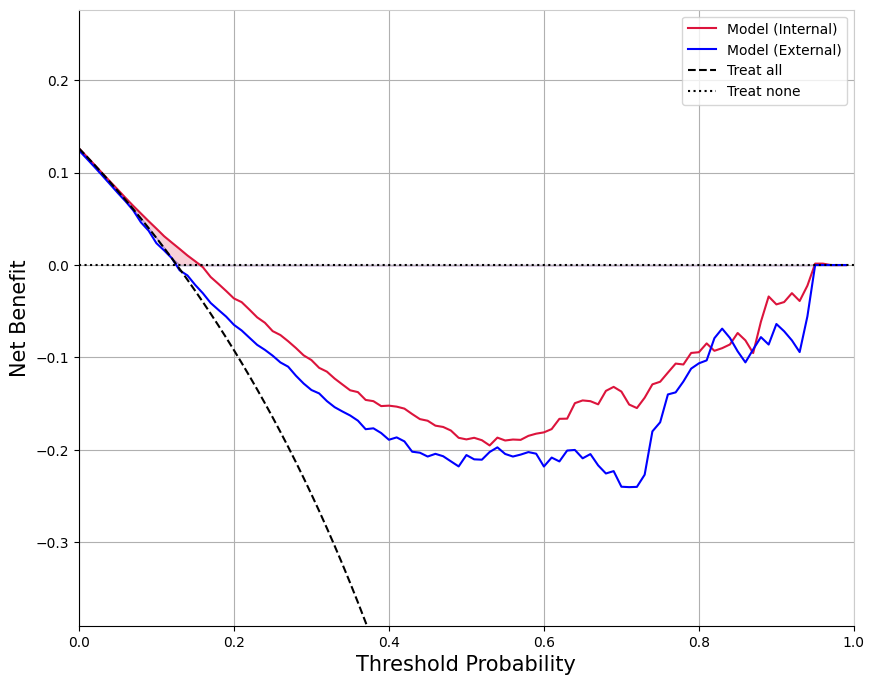

In [12]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
import pandas as pd

# 计算净效益函数
def calculate_net_benefit_model(thresh_group, y_pred_score, y_label):
    net_benefit_model = np.array([])
    for thresh in thresh_group:
        y_pred_label = y_pred_score > thresh
        tn, fp, fn, tp = confusion_matrix(y_label, y_pred_label).ravel()
        n = len(y_label)
        net_benefit = (tp / n) - (fp / n) * (thresh / (1 - thresh))
        net_benefit_model = np.append(net_benefit_model, net_benefit)
    return net_benefit_model

def calculate_net_benefit_all(thresh_group, y_label):
    net_benefit_all = np.array([])
    tn, fp, fn, tp = confusion_matrix(y_label, y_label).ravel()
    total = tp + tn
    for thresh in thresh_group:
        net_benefit = (tp / total) - (tn / total) * (thresh / (1 - thresh))
        net_benefit_all = np.append(net_benefit_all, net_benefit)
    return net_benefit_all

# 绘制DCA曲线
def plot_DCA(ax, thresh_group, net_benefit_internal, net_benefit_external, net_benefit_all):
    # 绘制曲线
    ax.plot(thresh_group, net_benefit_internal, color='crimson', label='Model (Internal)')
    ax.plot(thresh_group, net_benefit_external, color='blue', label='Model (External)')
    ax.plot(thresh_group, net_benefit_all, color='black', linestyle='--', label='Treat all')
    ax.plot((0, 1), (0, 0), color='black', linestyle=':', label='Treat none')

    # 填充区域
    y2 = np.maximum(net_benefit_all, 0)
    y1_internal = np.maximum(net_benefit_internal, y2)
    y1_external = np.maximum(net_benefit_external, y2)
    ax.fill_between(thresh_group, y1_internal, y2, color='crimson', alpha=0.2)
    ax.fill_between(thresh_group, y1_external, y2, color='blue', alpha=0.2)

    # 配置图形外观
    ax.set_xlim(0, 1)
    ax.set_ylim(min(net_benefit_internal.min(), net_benefit_external.min()) - 0.15,
                max(net_benefit_internal.max(), net_benefit_external.max()) + 0.15)
    ax.set_xlabel('Threshold Probability', fontdict={'family': 'Times New Roman', 'fontsize': 15})
    ax.set_ylabel('Net Benefit', fontdict={'family': 'Times New Roman', 'fontsize': 15})
    ax.grid(True)
    ax.spines['right'].set_color((0.8, 0.8, 0.8))
    ax.spines['top'].set_color((0.8, 0.8, 0.8))
    ax.legend(loc='upper right')

    return ax

# 计算交点并保存到CSV
def find_intersections_with_none(thresh_group, net_benefit_internal, net_benefit_external, net_benefit_all):
    intersections = []
    for i in range(1, len(thresh_group)):
        # 检查internal与treat none的交点
        if (net_benefit_internal[i-1] * net_benefit_internal[i]) < 0:
            intersections.append((thresh_group[i], 'Internal', 'None'))
        # 检查external与treat none的交点
        if (net_benefit_external[i-1] * net_benefit_external[i]) < 0:
            intersections.append((thresh_group[i], 'External', 'None'))
        # 检查treat all与treat none的交点
        if (net_benefit_all[i-1] * net_benefit_all[i]) < 0:
            intersections.append((thresh_group[i], 'Treat All', 'None'))

    # 将交点保存到CSV
    df_intersections = pd.DataFrame(intersections, columns=['Threshold', 'Line1', 'Line2'])
    df_intersections.to_csv('output_data_LOGISTIC/dca_intersections_with_none.csv', index=False)
    return df_intersections

# 定义阈值范围
thresh_group = np.arange(0, 1, 0.01)

# 计算各自的净效益
net_benefit_internal = calculate_net_benefit_model(thresh_group, y_pred_prob_internal, y_internal_selected_scaled)
net_benefit_external = calculate_net_benefit_model(thresh_group, y_pred_prob_external, y_external_selected_scaled)
net_benefit_all = calculate_net_benefit_all(thresh_group, y_internal_selected_scaled)  # Treat All 使用 internal 标签

# 找到与Treat None的交点并保存
intersections_with_none = find_intersections_with_none(thresh_group, net_benefit_internal, net_benefit_external, net_benefit_all)

# 绘制DCA曲线
fig, ax = plt.subplots(figsize=(10, 8))
ax = plot_DCA(ax, thresh_group, net_benefit_internal, net_benefit_external, net_benefit_all)
plt.savefig('output_data_LOGISTIC/roc_curves/dca_curve.png')
plt.show()


In [20]:
shap_values

(282, 19)

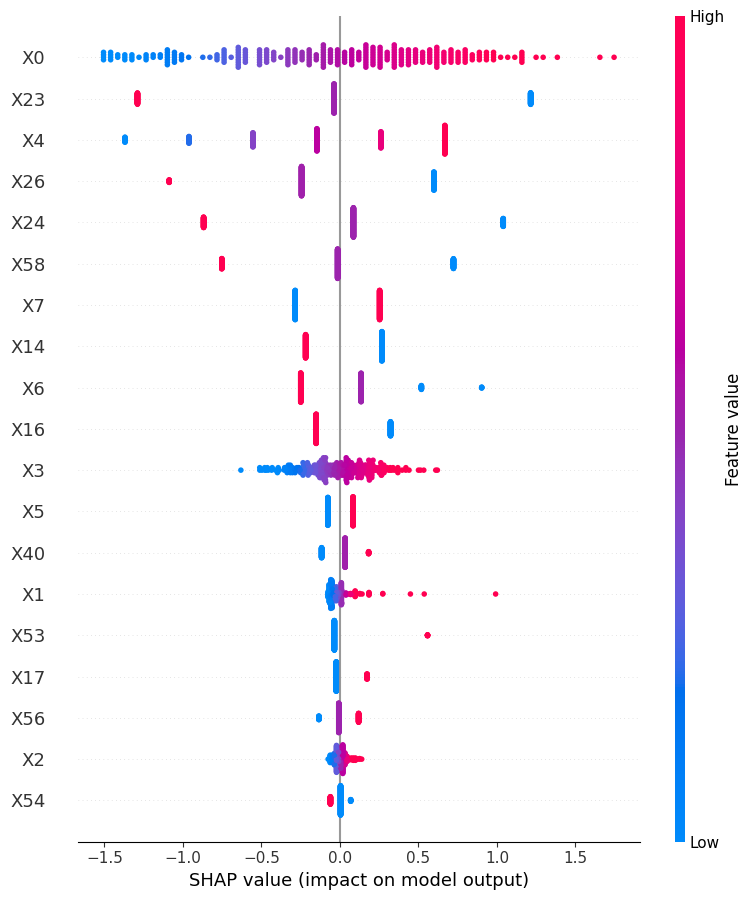

In [16]:
import shap
import joblib

# 加载最佳模型和测试数据
best_model = joblib.load('output_data_LOGISTIC/models/best_logistic_model.pkl')

# 生成SHAP值
explainer = shap.LinearExplainer(best_model, X_external_selected_scaled)
shap_values = explainer.shap_values(X_external_selected_scaled)

# 绘制SHAP图
shap.summary_plot(shap_values, X_external_selected_scaled)
# plt.savefig("output_data_LOGISTIC/roc_curves/shap_summary.png", bbox_inches='tight')
# plt.show()


In [28]:
shap_df = pd.DataFrame(shap_values, columns=X_external_selected_scaled.columns)
shap_df['Number'] = X_external_names
shap_df.to_csv('output_data_LOGISTIC/shap_values.csv', index=False)

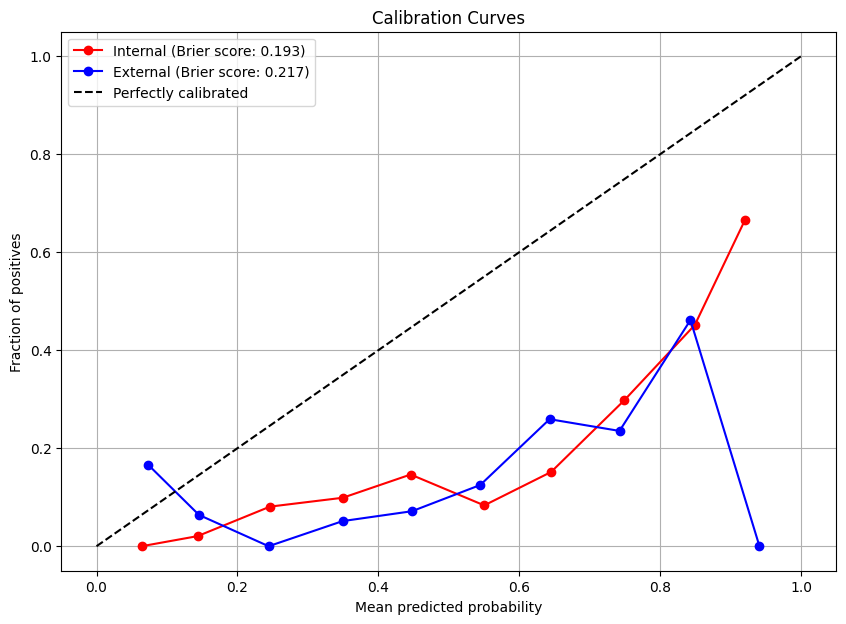

In [15]:
import matplotlib.pyplot as plt
from sklearn.calibration import calibration_curve
from sklearn.metrics import brier_score_loss
import numpy as np

# 加载最佳模型和数据
best_model = joblib.load('output_data_LOGISTIC/models/best_logistic_model.pkl')

# 预测 internal 和 external 数据集的概率
y_internal_pred_proba = best_model.predict_proba(X_internal_selected_scaled)[:, 1]
y_external_pred_proba = best_model.predict_proba(X_external_selected_scaled)[:, 1]

# 计算校准曲线
prob_true_internal, prob_pred_internal = calibration_curve(y_internal, y_internal_pred_proba, n_bins=10)
prob_true_external, prob_pred_external = calibration_curve(y_external, y_external_pred_proba, n_bins=10)

# 绘制校准曲线
plt.figure(figsize=(10, 7))
plt.plot(prob_pred_internal, prob_true_internal, marker='o', label='Internal (Brier score: {:.3f})'.format(
    brier_score_loss(y_internal, y_internal_pred_proba)), color='red')
plt.plot(prob_pred_external, prob_true_external, marker='o', label='External (Brier score: {:.3f})'.format(
    brier_score_loss(y_external, y_external_pred_proba)), color='blue')

# 绘制理想的校准曲线 (完全校准)
plt.plot([0, 1], [0, 1], linestyle='--', label='Perfectly calibrated', color='black')

plt.xlabel('Mean predicted probability')
plt.ylabel('Fraction of positives')
plt.title('Calibration Curves')
plt.legend()
plt.grid()
plt.savefig("output_data_LOGISTIC/roc_curves/calibration_curve.png", bbox_inches='tight')
plt.show()